# **Equity Index Futures Strategy**







In [ ]:
import numpy as np #General Library
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set()
import warnings
warnings.simplefilter('ignore')
matplotlib.use('WebAgg')
import seaborn as sn

In [ ]:
#pip install matplotlib==3.3.2
matplotlib.__version__

'3.2.2'

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Machine learning models
from sklearn.naive_bayes import GaussianNB #Gaussian Bayes
import xgboost as xgb #Extreme Gradient Boosting
from sklearn import tree #Decision Tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#Additional Library
#pip install talib-binary==0.4.17
#pip intall pyfolio
#pip install arch
#pip install alphalens

In [ ]:
pip install git+https://github.com/quantopian/pyfolio #correct pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-08twx95f
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-08twx95f
     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75764 sha256=2ea472c23591f3c1dc55ecc0ad1334b393599fb21755144655368c741142e948
  Stored in directory: /tmp/pip-ephem-wheel-cache-zom72f4q/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
  Created wheel for empyrical: filename=empyrical-0.5.5-cp37-none-any.whl size=39764 sha256=c4da2a5445598d4d669e1adb19f759e0a255cb9210d01ba5dede2a84c1af5314
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


In [ ]:
pip install talib-binary==0.4.17 #print(talib.get_function_groups())

     |████████████████████████████████| 3.3MB 4.4MB/s 


In [ ]:
#pip install empyrical==0.3.4

In [ ]:
import talib as tb
import pyfolio as pf
#import alphalens as al

**IMPORT DATA**

In [ ]:
from google.colab import drive #load data from gdrive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/EF4328_GROUP_DATA"

Mounted at /content/drive
/content/drive/My Drive/EF4328_GROUP_DATA


In [ ]:
EQUITY_FUT=pd.read_csv('/content/drive/MyDrive/EF4328_GROUP_DATA/EQUITY.csv',index_col=0, parse_dates=True)#.ffill().truncate(before=pd.Timestamp("1990-01-01"))
COMMODITY_FUT=pd.read_csv('/content/drive/MyDrive/EF4328_GROUP_DATA/COMMODITY.csv',index_col=0, parse_dates=True)
CURRENCY_FUT=pd.read_csv('/content/drive/MyDrive/EF4328_GROUP_DATA/CURRENCY.csv',index_col=0, parse_dates=True)
BOND_FUT=pd.read_csv('/content/drive/MyDrive/EF4328_GROUP_DATA/BOND.csv',index_col=0, parse_dates=True)
EQUITY_FUT.index=EQUITY_FUT.index.tz_localize('US/Eastern')
COMMODITY_FUT.index=COMMODITY_FUT.index.tz_localize('US/Eastern')
CURRENCY_FUT.index=CURRENCY_FUT.index.tz_localize('US/Eastern')
BOND_FUT=BOND_FUT.index.tz_localize('US/Eastern')

In [ ]:
def compute_ret(df,n): #compare strategy and benchmark return
  bench='return_next_day'
  benchmark_ret=df[bench]
  #strategy ret
  name='strat'+str(n)

**DATA CLEANING**

In [ ]:
dfe=EQUITY_FUT.copy() #Equity Final
ES=dfe[dfe.columns[:18]]
DM=dfe[dfe.columns[18:36]]
NQ=dfe[dfe.columns[36:]]
#Commodity
dfc=COMMODITY_FUT.copy()
C=dfc[dfc.columns[:18]]
CO=dfc[dfc.columns[18:36]]
CL=dfc[dfc.columns[36:54]]
W=dfc[dfc.columns[54:72]]
S=dfc[dfc.columns[72:90]]
#Currency
dfcr=CURRENCY_FUT.copy()
AD=dfcr[dfcr.columns[:18]]
CD=dfcr[dfcr.columns[18:36]]
SF=dfcr[dfcr.columns[36:54]]
EC=dfcr[dfcr.columns[54:72]]
JY=dfcr[dfcr.columns[72:90]]
list_assets=[ES,DM,NQ,C,CO,CL,W,S,AD,CD,SF,EC,JY]
ES_df=ES.copy()
DM_df=DM.dropna()
NQ_df=NQ.dropna()
C_df=C.dropna()
CO_df=CO.dropna()
CL_df=CL.dropna()
W_df=W.dropna()
S_df=S.dropna()
AD_df=AD.dropna()
CD_df=CD.dropna()
SF_df=SF.dropna()
EC_df=EC.dropna()
JY_df=JY.dropna()
list_df=[ES_df,DM_df,NQ_df,C_df,CO_df,CL_df,W_df,S_df,AD_df,CD_df,SF_df,EC_df,JY_df]

In [ ]:
#print(ES.isnull().sum())
#print(DM.isnull().sum())
#print(NQ.isnull().sum())

# **2. Exploratory Data Analysis**

In [ ]:
pd.set_option('precision',2) #Descriptive Statistics
ES_df.head(1)

,ES1 Index_PX_OPEN,ES1 Index_PX_LAST,ES1 Index_PX_HIGH,ES1 Index_PX_LOW,ES1 Index_PX_VOLUME,ES1 Index_OPEN_INT,ES1 Index_FUT_AGGTE_OPEN_INT,ES1 Index_AGGREGATE_CALL_OPEN_INT,ES1 Index_AGGREGATE_PUT_OPEN_INT,ES2 Index_PX_OPEN,ES2 Index_PX_LAST,ES2 Index_PX_HIGH,ES2 Index_PX_LOW,ES2 Index_PX_VOLUME,ES2 Index_OPEN_INT,ES2 Index_FUT_AGGTE_OPEN_INT,ES2 Index_AGGREGATE_CALL_OPEN_INT,ES2 Index_AGGREGATE_PUT_OPEN_INT
Dates,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,1489.0,1466.75,1496.0,1452.25,61938,13954,13967,384,426,1513.0,1485.75,1513.25,1468.5,4,13,13967,384,426


**2.2 Define Parameters**

In [ ]:
#Daily pct change
ES_df['daily_pct_change']=ES_df['ES1 Index_PX_LAST'].pct_change()
DM_df['daily_pct_change']=DM_df['DM1 Index_PX_LAST'].pct_change()
NQ_df['daily_pct_change']=NQ_df['NQ1 Index_PX_LAST'].pct_change()
C_df['daily_pct_change']=C_df['C 1 Comdty_PX_LAST'].pct_change()
CO_df['daily_pct_change']=CO_df['CO1 Comdty_PX_LAST'].pct_change()
CL_df['daily_pct_change']=CL_df['CL1 Comdty_PX_LAST'].pct_change()
W_df['daily_pct_change']=W_df['W 1 Comdty_PX_LAST'].pct_change()
S_df['daily_pct_change']=S_df['S 1 Comdty_PX_LAST'].pct_change()
#Target Var
ES_df['return_next_day']=ES_df['daily_pct_change'].shift(-1)
DM_df['return_next_day']=DM_df['daily_pct_change'].shift(-1)
NQ_df['return_next_day']=NQ_df['daily_pct_change'].shift(-1)
C_df['return_next_day']=C_df['daily_pct_change'].shift(-1)
CO_df['return_next_day']=CO_df['daily_pct_change'].shift(-1)
CL_df['return_next_day']=CL_df['daily_pct_change'].shift(-1)
W_df['return_next_day']=W_df['daily_pct_change'].shift(-1)
S_df['return_next_day']=S_df['daily_pct_change'].shift(-1)
ES_df['actual_signal']=np.where(ES_df.return_next_day>0,1,-1)
DM_df['actual_signal']=np.where(DM_df.return_next_day>0,1,-1)
NQ_df['actual_signal']=np.where(NQ_df.return_next_day>0,1,-1)
C_df['actual_signal']=np.where(C_df.return_next_day>0,1,-1)
CO_df['actual_signal']=np.where(CO_df.return_next_day>0,1,-1)
CL_df['actual_signal']=np.where(CL_df.return_next_day>0,1,-1)
W_df['actual_signal']=np.where(W_df.return_next_day>0,1,-1)
S_df['actual_signal']=np.where(S_df.return_next_day>0,1,-1)
#cum ret
ES_df['cum_ret']=(1+ES_df['daily_pct_change']).cumprod()
DM_df['cum_ret']=(1+DM_df['daily_pct_change']).cumprod()
NQ_df['cum_ret']=(1+NQ_df['daily_pct_change']).cumprod()
C_df['cum_ret']=(1+C_df['daily_pct_change']).cumprod()
CO_df['cum_ret']=(1+CO_df['daily_pct_change']).cumprod()
CL_df['cum_ret']=(1+CL_df['daily_pct_change']).cumprod()
W_df['cum_ret']=(1+W_df['daily_pct_change']).cumprod()
S_df['cum_ret']=(1+S_df['daily_pct_change']).cumprod()

2.3 Baseline Features: Linear Correlation

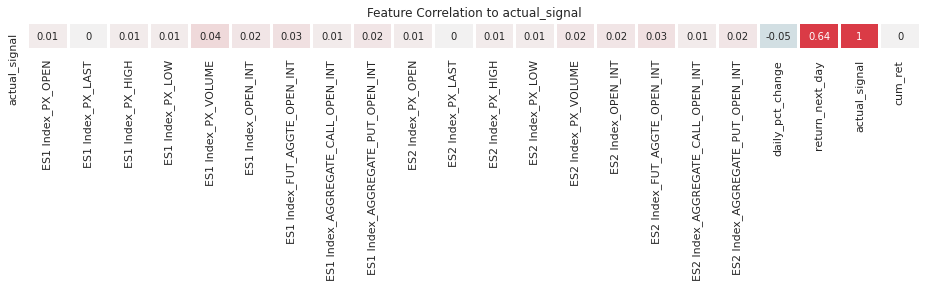

In [ ]:
# Plot Correlation to Target Variable only
cmap = sns.diverging_palette(220, 10, as_cmap=True)
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False): 
    #target signal you want, can be single/multiple signal
    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0, cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')
    
    if(ret_id):
        return corr
corrMat(ES_df,'actual_signal',figsize=(16,0.5))

**2.4 Feature Engineering**

In [ ]:
# Create the predictors
predictor_list = []
def mom(df,n): #Calculation of momentum
  t=df.pct_change()
  return pd.Series(t.rolling(n).mean(), name='Momentum_' + str(n))
def carry(df,df2,n=12): #Calculation of carry, Default 12
  cry=(df/df2)-1
  return pd.Series(cry.rolling(n).mean(),name='Carry_'+str(n))
def ema(df,n):
   return pd.Series(df.ewm(span=n,min_periods=n).mean(), name='EMA_' + str(n))
def enhance_oi(df,df2,n): #df1 open interest and df2 return.Option weekly expire
  oi=df/df2
  oi_ret=(oi-oi.rolling(n).mean())/oi.rolling(n).std()
  return pd.Series(oi_ret,name='OI_'+str(n))
def rev(df,n):#df is cumret,Large-cap/low-volatility
  return pd.Series((df.rolling(n).mean()-df)/df.rolling(n).std())
def strat_bband(df,n): #n optimal 5, 30,  15 
    upperband, middleband, lowerband = tb.BBANDS(df, timeperiod=n, nbdevup=2.25, nbdevdn=2.25, matype=0)
    return pd.Series(np.where(df>upperband,-1,np.where(df<lowerband,1,0)))


In [ ]:
def rz_indicator(true_df,ldf,ldf2,ldf3,ldf4,tr_id=True): 
  #ldf2=OI, ldf3=cumret, ldf4=2nd month last_px,
    #Momentum 
    true_df['MOM120'] = mom(ldf,128) #short 6 month
    true_df['MOM240'] = mom(ldf, 252) #long 1 year
    lst_MOM = ['MOM120','MOM240']
    #Carry
    true_df['CARRY22'] = carry(ldf,ldf4, 22)
    true_df['CARRY120'] = carry(ldf,ldf4, 128)
    true_df['CARRY240'] = carry(ldf,ldf4, 251)
    lst_CRY = ['CARRY10','CARRY20','CARRY40']
    #Enhance_OI
    true_df['OI5']=enhance_oi(ldf2,ldf,5)
    true_df['OI20']=enhance_oi(ldf2,ldf,20)
    true_df['OI60']=enhance_oi(ldf2,ldf,60)
    true_df['OI120']=enhance_oi(ldf2,ldf,120)
    true_df['OI240']=enhance_oi(ldf2,ldf,240)
    lst_OI=['OI5','OI20','OI60','OI120','OI240']
    #Mean Reversion
    true_df['REV20']=rev(ldf3,20)
    true_df['REV60']=rev(ldf3,64)
    true_df['REV120']=rev(ldf3,128)
    true_df['REV240']=rev(ldf3,251)
    lst_MR=['REV20','REV60','REV120','REV240']
  #real=tb.ATR(NQ_df['NQ1 Index_PX_HIGH'],NQ_df['NQ1 Index_PX_LOW'],NQ_df['NQ1 Index_PX_LAST'],timeperiod=14)
#upperband, middleband, lowerband = tb.BBANDS(NQ_df['NQ1 Index_PX_LAST'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0) #Quite General


## **Indicator Generation**

In [ ]:
rz_indicator(ES_df,ES_df['ES1 Index_PX_LAST'],ES_df['ES1 Index_FUT_AGGTE_OPEN_INT'],ES_df['cum_ret'],ES_df['ES2 Index_PX_LAST'],True)
rz_indicator(DM_df,DM_df['DM1 Index_PX_LAST'],DM_df['DM1 Index_FUT_AGGTE_OPEN_INT'],DM_df['cum_ret'],DM_df['DM2 Index_PX_LAST'],True)
rz_indicator(NQ_df,NQ_df['NQ1 Index_PX_LAST'],NQ_df['NQ1 Index_FUT_AGGTE_OPEN_INT'],NQ_df['cum_ret'],NQ_df['NQ2 Index_PX_LAST'],True)
rz_indicator(C_df,C_df['C 1 Comdty_PX_LAST'],C_df['C 1 Comdty_FUT_AGGTE_OPEN_INT'],C_df['cum_ret'],C_df['C 2 Comdty_PX_LAST'],True)
rz_indicator(CO_df,CO_df['CO1 Comdty_PX_LAST'],CO_df['CO1 Comdty_FUT_AGGTE_OPEN_INT'],CO_df['cum_ret'],CO_df['CO2 Comdty_PX_LAST'],True)
rz_indicator(CL_df,CL_df['CL1 Comdty_PX_LAST'],CL_df['CL1 Comdty_FUT_AGGTE_OPEN_INT'],CL_df['cum_ret'],CL_df['CL2 Comdty_PX_LAST'],True)
rz_indicator(W_df,W_df['W 1 Comdty_PX_LAST'],W_df['W 1 Comdty_FUT_AGGTE_OPEN_INT'],W_df['cum_ret'],W_df['W 2 Comdty_PX_LAST'],True)
rz_indicator(S_df,S_df['S 1 Comdty_PX_LAST'],S_df['S 1 Comdty_FUT_AGGTE_OPEN_INT'],S_df['cum_ret'],S_df['S 2 Comdty_PX_LAST'],True)


## **Clean data after adding indicators**


In [ ]:
#Drop remaining missing data
ES_dfU=ES_df.copy().dropna()
DM_dfU=DM_df.copy().dropna()
NQ_dfU=NQ_df.copy().dropna()
C_dfU=C_df.copy().dropna()
CO_dfU=CO_df.copy().dropna()
CL_dfU=CL_df.copy().dropna()
W_dfU=W_df.copy().dropna()
S_dfU=S_df.copy().dropna()

In [ ]:
ES_dfU[['OI5','OI20','OI60','OI120','OI240','REV20','REV60','REV120','REV240','return_next_day']].head(1)

,OI5,OI20,OI60,OI120,OI240,REV20,REV60,REV120,REV240,return_next_day
Dates,,,,,,,,,,
2000-12-20 00:00:00-05:00,-0.103067,-1.414357,-0.814822,-0.1403,0.439568,2.56613,2.302564,2.519436,2.809661,0.006643


# **3. Emprical Model Analysis**

In [ ]:
def strat(true_df):
  #momentum
  true_df['signal_MOM120']=np.where(true_df['MOM120']>0,1,-1)
  true_df['MOM120_ret']=true_df['signal_MOM120']*true_df.return_next_day
  true_df['signal_MOM240']=np.where(true_df['MOM240']>0,1,-1)
  true_df['MOM240_ret']=true_df['signal_MOM240']*true_df.return_next_day
  #Carry
  true_df['signal_CARRY22']=np.where(true_df['CARRY22']>0,1,-1)
  true_df['CARRY22_ret']=true_df['signal_CARRY22']*true_df.return_next_day
  true_df['signal_CARRY120']=np.where(true_df['CARRY120']>0,1,-1)
  true_df['CARRY120_ret']=true_df['signal_CARRY120']*true_df.return_next_day
  true_df['signal_CARRY240']=np.where(true_df['CARRY240']>0,1,-1)
  true_df['CARRY240_ret']=true_df['signal_CARRY240']*true_df.return_next_day
  #Enhance Open Interest
  true_df['signal_OI5']=np.where(true_df['OI5']>0,1,-1)
  true_df['OI5_ret']=true_df['signal_OI5']*true_df.return_next_day
  true_df['signal_OI20']=np.where(true_df['OI20']>0,1,-1)
  true_df['OI20_ret']=true_df['signal_OI20']*true_df.return_next_day
  true_df['signal_OI60']=np.where(true_df['OI60']>0,1,-1)
  true_df['OI60_ret']=true_df['signal_OI60']*true_df.return_next_day
  true_df['signal_OI120']=np.where(true_df['OI120']>0,1,-1)
  true_df['OI120_ret']=true_df['signal_OI120']*true_df.return_next_day
  true_df['signal_OI240']=np.where(true_df['OI240']>0,1,-1)
  true_df['OI240_ret']=true_df['signal_OI240']*true_df.return_next_day
  #====Strategy Combination===
  #1. OI MOM
  true_df['signal_OI_MOM']=np.where((true_df['signal_OI5']==1) & (true_df['signal_MOM240']==1),1,np.where((true_df['signal_OI5']==-1)& (true_df['signal_MOM240']==-1),-1,0))
  true_df['OI_MOM_ret']=true_df['signal_OI_MOM']*true_df.return_next_day
  #2. OI CARRY
  true_df['signal_OI_CARRY']=np.where((true_df['signal_OI5']==1) & (true_df['signal_CARRY240']==1),1,np.where((true_df['signal_OI5']==-1) &(true_df['signal_CARRY240']==-1),-1,0))
  true_df['OI_CARRY_ret']=true_df['signal_OI_CARRY']*true_df.return_next_day
  #3. CARRY MOM
  true_df['signal_CARRY_MOM']=np.where((true_df['signal_CARRY240']==1)&(true_df['signal_MOM240']==1),1,np.where((true_df['signal_CARRY240']==-1)&(true_df['signal_MOM240']==-1),-1,0))
  true_df['CARRY_MOM_ret']=true_df['signal_CARRY_MOM']*true_df.return_next_day
  #4. OI CARRY MOM
  true_df['signal_OI_CARRY_MOM']=np.where((true_df['signal_CARRY240']==1)&(true_df['signal_MOM240']==1)&(true_df['signal_OI5']==1),1,np.where((true_df['signal_CARRY240']==-1)&(true_df['signal_MOM240']==-1)&(true_df['signal_OI5']==-1),-1,0))
  true_df['OI_CARRY_MOM_ret']=true_df['signal_OI_CARRY_MOM']*true_df.return_next_day
  #Benchmark copy
  true_df['benchmark_ret']=true_df['daily_pct_change'].copy()
strat(ES_dfU)
strat(DM_dfU)
strat(NQ_dfU)
strat(C_dfU)
strat(CO_dfU)
strat(CL_dfU)
strat(W_dfU)
strat(S_dfU)

In [ ]:
ret_type_list=['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','REV20_ret','REV60_ret','REV120_ret','REV240_ret','OI5_ret','OI20_ret','OI60_ret','OI120_ret','OI240_ret']
ret_combination_list=['OI_MOM_ret','OI_CARRY_ret','CARRY_MOM_ret','OI_CARRY_MOM_ret']

In [ ]:
#Export to CSV ===Return ONLY====
#ES_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('ES.csv')
#DM_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('DM.csv')
#NQ_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('NQ.csv')
#C_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('C.csv')
#CO_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('CO.csv')
#CL_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('CL.csv')
#W_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('W.csv')
#S_dfU[['MOM120_ret','MOM240_ret','CARRY22_ret','CARRY120_ret','CARRY240_ret','OI5_ret','OI20_ret']].to_csv('S.csv')

In [ ]:
#Export to CSV ===Return and pos === (Discretionary plz)
ES_dfU[ES_dfU.columns[-20:]].to_csv('ES2.csv')
DM_dfU[DM_dfU.columns[-20:]].to_csv('DM2.csv')
NQ_dfU[NQ_dfU.columns[-20:]].to_csv('NQ2.csv')
C_dfU[C_dfU.columns[-20:]].to_csv('C2.csv')
CO_dfU[CO_dfU.columns[-20:]].to_csv('CO2.csv')
CL_dfU[CL_dfU.columns[-20:]].to_csv('CL2.csv')
W_dfU[W_dfU.columns[-20:]].to_csv('W2.csv')
S_dfU[S_dfU.columns[-20:]].to_csv('S2.csv')

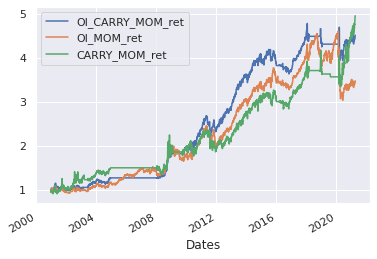

In [ ]:
(1+ES_dfU['OI_CARRY_MOM_ret']).cumprod().plot()
(1+ES_dfU['OI_MOM_ret']).cumprod().plot()
(1+ES_dfU['CARRY_MOM_ret']).cumprod().plot()

plt.legend()


##**Sample Portfolio Allocation**

# **4. Model Generation**

In [ ]:
#Training and testing data for Machine Learning
ES_X_train,ES_X_test, ES_y_train, ES_y_test = train_test_split(ES_dfU.drop('actual_signal',axis=1),ES_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
DM_X_train,DM_X_test, DM_y_train, DM_y_test = train_test_split(DM_dfU.drop('actual_signal',axis=1),DM_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
NQ_X_train,NQ_X_test, NQ_y_train, NQ_y_test = train_test_split(NQ_dfU.drop('actual_signal',axis=1),NQ_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
C_X_train,C_X_test, C_y_train, C_y_test = train_test_split(C_dfU.drop('actual_signal',axis=1),C_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
CO_X_train,CO_X_test, CO_y_train, CO_y_test = train_test_split(CO_dfU.drop('actual_signal',axis=1),CO_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
CL_X_train,CL_X_test, CL_y_train, CL_y_test = train_test_split(CL_dfU.drop('actual_signal',axis=1),CL_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
W_X_train,W_X_test, W_y_train, W_y_test = train_test_split(W_dfU.drop('actual_signal',axis=1),W_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)
S_X_train,S_X_test, S_y_train, S_y_test = train_test_split(S_dfU.drop('actual_signal',axis=1),S_dfU['actual_signal'],test_size=0.3,random_state=1,shuffle=False)

In [ ]:
models = [] #Models list
#Straight away Advanced ML Models 
models.append(('XGB',xgb.XGBClassifier(max_depth=2,n_estimators=25)))
models.append(('RF', RandomForestClassifier(max_depth=2,n_estimators=25)))
models1 = [] #Models list
#Straight away Advanced ML Models 
models1.append(('XGB',xgb.XGBClassifier(max_depth=2,n_estimators=25)))
models1.append(('RF', RandomForestClassifier(max_depth=2,n_estimators=25)))
models2 = [] #Models list
#Straight away Advanced ML Models 
models2.append(('XGB',xgb.XGBClassifier(max_depth=2,n_estimators=25)))
models2.append(('RF', RandomForestClassifier(max_depth=2,n_estimators=25)))


In [ ]:
ES_X_train[['MOM240','CARRY240','OI5']]
DM_X_train[['MOM240','CARRY240','OI5']]
NQ_X_train[['MOM240','CARRY240','OI5']]
ES_X_test[['MOM240','CARRY240','OI5']]
DM_X_test[['MOM240','CARRY240','OI5']]
NQ_X_test[['MOM240','CARRY240','OI5']].head(1)
ES_y_train.head(3)

Dates
2000-12-20 00:00:00-05:00    1
2000-12-21 00:00:00-05:00    1
2000-12-22 00:00:00-05:00   -1
Name: actual_signal, dtype: int64

## **Cross Validation in the Training Datasets**

In [ ]:
## Initialize the KFold parameters ES
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(models[0][1], ES_X_train[['MOM240','CARRY240','OI5']], ES_y_train, cv=kfold) #models[1][1] for RF
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 50.72% (2.37%)


In [ ]:
## Initialize the KFold parameters DM
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(models1[0][1], DM_X_train[['MOM240','CARRY240','OI5']], DM_y_train, cv=kfold) #models[1][1] for RF
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 51.61% (1.66%)


In [ ]:
## Initialize the KFold parameters NQ
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(models2[0][1], NQ_X_train[['MOM240','CARRY240','OI5']], NQ_y_train, cv=kfold) #models[1][1] for RF
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 51.51% (1.31%)


RuntimeError: ignored

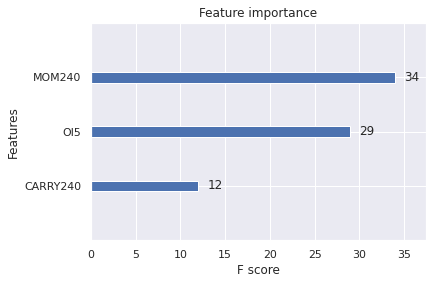

In [ ]:
#train the model ES
models[0][1].fit(ES_X_train[['MOM240','CARRY240','OI5']],ES_y_train)
# Plot the top 7 features
xgb.plot_importance(models[0][1], max_num_features=3)
# Show the plot
plt.show()

RuntimeError: ignored

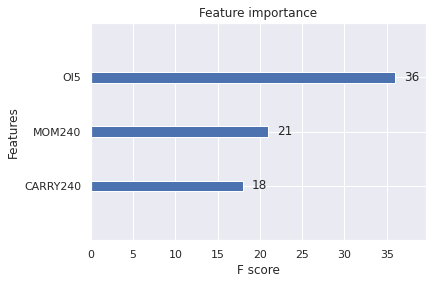

In [ ]:
#train the model DM 
models1[0][1].fit(DM_X_train[['MOM240','CARRY240','OI5']],DM_y_train)
# Plot the top 7 features
# Plot the top 7 features
xgb.plot_importance(models1[0][1], max_num_features=3)
# Show the plot
plt.show()

RuntimeError: ignored

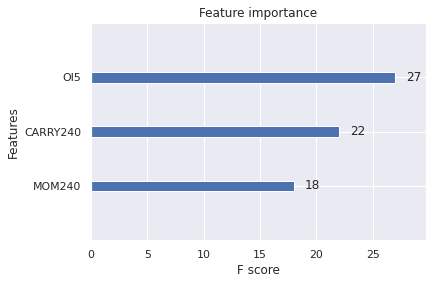

In [ ]:
#train the model NQ 
models2[0][1].fit(NQ_X_train[['MOM240','CARRY240','OI5']],NQ_y_train)
# Plot the top 7 features
xgb.plot_importance(models2[0][1], max_num_features=3)
# Show the plot
plt.show()

## **Predicted Signal**

In [ ]:
ES_dfU['predicted_signal']=models[0][1].predict(ES_dfU[['MOM240','CARRY240','OI5']])
DM_dfU['predicted_signal']=models1[0][1].predict(DM_dfU[['MOM240','CARRY240','OI5']])
NQ_dfU['predicted_signal']=models2[0][1].predict(NQ_dfU[['MOM240','CARRY240','OI5']])


In [ ]:
ES_dfU['XGBOOST_ret']=ES_dfU['predicted_signal']*ES_dfU.return_next_day
DM_dfU['XGBOOST_ret']=DM_dfU['predicted_signal']*DM_dfU.return_next_day
NQ_dfU['XGBOOST_ret']=NQ_dfU['predicted_signal']*NQ_dfU.return_next_day


In [ ]:
# Predict the trading signal on test dataset
y_pred = models1[0][1].predict(DM_X_test[['MOM240','CARRY240','OI5']])
# Get the classification report
print(classification_report(DM_y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.48      0.47      0.47       591
           1       0.55      0.56      0.56       686

    accuracy                           0.52      1277
   macro avg       0.52      0.51      0.51      1277
weighted avg       0.52      0.52      0.52      1277



## **Classification Report**

In [ ]:
# Predict the trading signal on test dataset
y_pred = models[0][1].predict(ES_X_test[['MOM240','CARRY240','OI5']])
# Get the classification report
print(classification_report(ES_y_test, y_pred))

In [ ]:
# Predict the trading signal on test dataset
y_pred = models[0][1].predict(ES_X_test[['MOM240','CARRY240','OI5']])
# Get the classification report
print(classification_report(ES_y_test, y_pred))

In [ ]:
# Predict the trading signal on test dataset
y_pred = models[0][1].predict(ES_X_test[['MOM240','CARRY240','OI5']])
# Get the classification report
print(classification_report(ES_y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.41      0.15      0.22       753
           1       0.51      0.81      0.63       837

    accuracy                           0.50      1590
   macro avg       0.46      0.48      0.42      1590
weighted avg       0.47      0.50      0.43      1590



In [ ]:
#Confusion Matrix
array = confusion_matrix(ES_y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **5. Backtest**

### **Individual Ret**

In [ ]:
def individual_ret(df):  
  plt.figure(figsize=(16,8))
  (1+df['MOM240_ret']).cumprod().plot()
  (1+df['CARRY240_ret']).cumprod().plot()
  (1+df['OI5_ret']).cumprod().plot()
  (1+df['OI_CARRY_MOM_ret']).cumprod().plot()
  #(1+df['benchmark_ret']).cumprod().plot()
  plt.legend()
  plt.axvline('2015-01-01 00:00:00-05:00', 0, 1, label='Out of Sample |')
  plt.title(df.columns[0][:2]+ " Cumulative Return Strategy") 
  plt.show()
def ml_ret(df):  
  plt.figure(figsize=(16,8))
  (1+df['XGBOOST_ret']).cumprod().plot()
  (1+df['benchmark_ret']).cumprod().plot()
  plt.legend()
  plt.axvline('2015-01-01 00:00:00-05:00', 0, 1, label='Out of Sample |')
  plt.title(" Global Equity XGBOOST Cumulative Return Strategy") #df.columns[0][:2]+
  plt.show()

In [ ]:
f_list=[ES_dfU,DM_dfU,NQ_dfU,C_dfU,CO_dfU,CL_dfU,W_dfU,S_dfU]
for i in f_list:
  individual_ret(i)

In [ ]:
#Individual in Depth Statistics
#for i in f_list:
 #print( i.columns[0][:2]+" In Depth Statistics")
 #pf.create_full_tear_sheet(i['MOM240_ret'],benchmark_rets=i['benchmark_ret'],live_start_date='2015-01-01') #For example
 #pf.create_full_tear_sheet(i['CARRY240_ret'],benchmark_rets=i['benchmark_ret'],live_start_date='2015-01-01') 
 #pf.create_full_tear_sheet(i['OI5_ret'],benchmark_rets=i['benchmark_ret'],live_start_date='2015-01-01')
 #pf.create_full_tear_sheet(i['OI_CARRY_MOM_ret'],benchmark_rets=i['benchmark_ret'],live_start_date='2015-01-01')

In [ ]:
pf.create_full_tear_sheet(equity_ml['XGBOOST_ret'],benchmark_rets=equity_ml_total['benchmark_ret'],live_start_date='2015-01-01',slippage=0.01)

## **Portfolio Ret**

In [ ]:
#Global Strategy Return 
RTZ_equity=pd.DataFrame()
RTZ_commodity=pd.DataFrame()
RTZ_total=pd.DataFrame()
RTZ_equity['MOM240_ret']=ES_dfU['MOM240_ret']+DM_dfU['MOM240_ret']+NQ_dfU['MOM240_ret']
RTZ_equity['CARRY240_ret']=ES_dfU['CARRY240_ret']+DM_dfU['CARRY240_ret']+NQ_dfU['CARRY240_ret']
RTZ_equity['OI5_ret']=ES_dfU['OI5_ret']+DM_dfU['OI5_ret']+NQ_dfU['OI5_ret']
RTZ_equity['OI_CARRY_MOM_ret']=ES_dfU['OI_CARRY_MOM_ret']+DM_dfU['OI_CARRY_MOM_ret']+NQ_dfU['OI_CARRY_MOM_ret']
RTZ_equity['benchmark_ret']=ES_dfU['benchmark_ret']+DM_dfU['benchmark_ret']+NQ_dfU['benchmark_ret']
RTZ_commodity['MOM240_ret']=C_dfU['MOM240_ret']+CO_dfU['MOM240_ret']+CL_dfU['MOM240_ret']+W_dfU['MOM240_ret']+S_dfU['MOM240_ret']
RTZ_commodity['CARRY240_ret']=C_dfU['CARRY240_ret']+CO_dfU['CARRY240_ret']+CL_dfU['CARRY240_ret']+W_dfU['CARRY240_ret']+S_dfU['CARRY240_ret']
RTZ_commodity['OI5_ret']=C_dfU['OI5_ret']+CO_dfU['OI5_ret']+CL_dfU['OI5_ret']+W_dfU['OI5_ret']+S_dfU['OI5_ret']
RTZ_commodity['OI_CARRY_MOM_ret']=C_dfU['OI_CARRY_MOM_ret']+CO_dfU['OI_CARRY_MOM_ret']+CL_dfU['OI_CARRY_MOM_ret']+W_dfU['OI_CARRY_MOM_ret']+S_dfU['OI_CARRY_MOM_ret']
RTZ_commodity['benchmark_ret']=C_dfU['benchmark_ret']+CO_dfU['benchmark_ret']+CL_dfU['benchmark_ret']+W_dfU['benchmark_ret']+S_dfU['benchmark_ret']
RTZ_total['MOM240_ret']=RTZ_equity['MOM240_ret']+RTZ_commodity['MOM240_ret']
RTZ_total['CARRY240_ret']=RTZ_equity['CARRY240_ret']+RTZ_commodity['CARRY240_ret']
RTZ_total['OI5_ret']=RTZ_equity['OI5_ret']+RTZ_commodity['OI5_ret']
RTZ_total['OI_CARRY_MOM_ret']=RTZ_equity['OI_CARRY_MOM_ret']+RTZ_commodity['OI_CARRY_MOM_ret']
RTZ_equity=RTZ_equity.dropna()
RTZ_commodity=RTZ_commodity.dropna()
RTZ_total=RTZ_total.dropna()

In [ ]:
#Machine Learning Return Global Equity
equity_ml_total=pd.DataFrame()
equity_ml_total['XGBOOST_ret']=ES_dfU['XGBOOST_ret']+DM_dfU['XGBOOST_ret']+NQ_dfU['XGBOOST_ret']
equity_ml_total['benchmark_ret']=ES_dfU['benchmark_ret']+DM_dfU['benchmark_ret']+NQ_dfU['benchmark_ret']
equity_ml=equity_ml_total.dropna()
#ml_ret(ES_dfU)
#ml_ret(DM_dfU)
#ml_ret(NQ_dfU)
ml_ret(equity_ml)